In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
import sys
import argparse
import breizhcrops
import torch
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


# Functions for dataset definition

In [13]:
from torch.utils.data import DataLoader
from tqdm import tqdm
from torch.optim import Adam
import torch
import pandas as pd
import os
import sklearn.metrics


def get_datasets(datapath, mode, batchsize, preload_ram=False, level="L2A"):
    print(f"Setting up datasets in {os.path.abspath(datapath)}, level {level}")
    datapath = os.path.abspath(datapath)

    frh01 = breizhcrops.BreizhCrops(region="frh01", root=datapath,
                                    preload_ram=preload_ram, level=level)
    frh02 = breizhcrops.BreizhCrops(region="frh02", root=datapath,
                                    preload_ram=preload_ram, level=level)
    frh03 = breizhcrops.BreizhCrops(region="frh03", root=datapath,
                                    preload_ram=preload_ram, level=level)
    if not "validation_only" in mode:
            frh04 = breizhcrops.BreizhCrops(region="frh04", root=datapath,
                                            preload_ram=preload_ram, level=level)

    if mode == "evaluation" or mode == "evaluation1":
        traindatasets = torch.utils.data.ConcatDataset([frh01, frh02, frh03])
        testdataset = frh04
    elif mode == "validation_only":
        traindatasets = torch.utils.data.ConcatDataset([frh01, frh02])
        validationdataset = frh03
    elif mode == "validation_test":
        traindatasets = torch.utils.data.ConcatDataset([frh01, frh02])
        validationdataset = frh03
        testdataset = frh04
        
    elif mode == 'all_zones':
        traindatasets = frh01
        testdataset1 = frh02
        testdataset2 = frh03        
        testdataset3 = frh04
        
    else:
        raise ValueError("only --mode 'validation' or 'evaluation' allowed")
    meta = dict(
        ndims=13 if level=="L1C" else 10,
        num_classes=len(frh01.classes),
        sequencelength=45
    )

    return traindatasets, testdataset1, testdataset2, testdataset3, meta   

def get_dataloader(traindatasets,testdataset, validationdataset=None, batchsize=32, workers=0):
    traindataloader = DataLoader(traindatasets, batch_size=batchsize, shuffle=True, num_workers=workers)
    validationdataloader = DataLoader(validationdataset, batch_size=batchsize, shuffle=True, num_workers=workers)
    testdataloader = DataLoader(testdataset, batch_size=batchsize, shuffle=False, num_workers=workers)

    return traindataloader, validationdataloader, testdataloader

def get_dataloader2(traindatasets,testdataset1, testdataset2, testdataset3, batchsize=32, workers=0):
    traindataloader = DataLoader(traindatasets, batch_size=batchsize, shuffle=True, num_workers=workers)
    testdataloader1 = DataLoader(testdataset1, batch_size=batchsize, shuffle=True, num_workers=workers)
    testdataloader2 = DataLoader(testdataset2, batch_size=batchsize, shuffle=True, num_workers=workers)
    testdataloader3 = DataLoader(testdataset3, batch_size=batchsize, shuffle=True, num_workers=workers)

    return traindataloader, testdataloader1, testdataloader2, testdataloader3


def metrics(y_true, y_pred, training = False):
    accuracy = sklearn.metrics.accuracy_score(y_true, y_pred)
    kappa = sklearn.metrics.cohen_kappa_score(y_true, y_pred)
    f1_micro = sklearn.metrics.f1_score(y_true, y_pred, average="micro")
    f1_macro = sklearn.metrics.f1_score(y_true, y_pred, average="macro")
    f1_weighted = sklearn.metrics.f1_score(y_true, y_pred, average="weighted")
    recall_micro = sklearn.metrics.recall_score(y_true, y_pred, average="micro")
    recall_macro = sklearn.metrics.recall_score(y_true, y_pred, average="macro")
    recall_weighted = sklearn.metrics.recall_score(y_true, y_pred, average="weighted")
    precision_micro = sklearn.metrics.precision_score(y_true, y_pred, average="micro")
    precision_macro = sklearn.metrics.precision_score(y_true, y_pred, average="macro")
    precision_weighted = sklearn.metrics.precision_score(y_true, y_pred, average="weighted")
    
    if training == True:
        return accuracy
    
    return dict(
        accuracy=accuracy,
        kappa=kappa,
        f1_micro=f1_micro,
        f1_macro=f1_macro,
        f1_weighted=f1_weighted,
        recall_micro=recall_micro,
        recall_macro=recall_macro,
        recall_weighted=recall_weighted,
        precision_micro=precision_micro,
        precision_macro=precision_macro,
        precision_weighted=precision_weighted,
    )

# Define params

In [14]:
zones = 4
input_dim=13
num_classes=9
d_model=64
n_head=2
n_layers=3
d_inner=128

In [15]:
datapath = Path('breizhcrops_dataset')
mode = 'all_zones'
batch_size = 256
learning_rate = 0.001

weight_decay = 5e-08
workers = 4

# Define Dataloader

In [16]:
zone1dataset, zone2dataset, zone3dataset, zone4dataset, meta = get_datasets(datapath=datapath, mode=mode,
                                                        batchsize=batch_size, 
                                                        preload_ram=True, level="L2A")
num_classes = meta["num_classes"]
ndims = meta["ndims"]
sequencelength = meta["sequencelength"]

Setting up datasets in /home/mauromartini/mauro_ws/Jupyter_notebooks/breizhcrops_dataset, level L2A


loading data into RAM: 100%|██████████| 122708/122708 [00:39<00:00, 3108.53it/s]


In [17]:
def reduce_random_dataset(full_dataset, new_size = 10000):

    residual = len(full_dataset) - new_size
    reduced_dataset, _ = torch.utils.data.random_split(full_dataset, [new_size,residual], generator=torch.Generator().manual_seed(42))
    
    return reduced_dataset

In [18]:
full_datasets = [zone1dataset, zone2dataset, zone3dataset, zone4dataset]
new_datasets = []
for i in range(zones):
    print('Full Dataset {} len: '.format(str(i+1)), full_datasets[i].__len__())
    new = reduce_random_dataset(full_datasets[i])
    new_datasets.append(new)
    print('Reduced Dataset {} len: '.format(str(i+1)), new.__len__())

zone1dataset_new = new_datasets[0]
zone2dataset_new = new_datasets[1]
zone3dataset_new = new_datasets[2]
zone4dataset_new = new_datasets[3]

Full Dataset 1 len:  178632
Reduced Dataset 1 len:  10000
Full Dataset 2 len:  140782
Reduced Dataset 2 len:  10000
Full Dataset 3 len:  166367
Reduced Dataset 3 len:  10000
Full Dataset 4 len:  122708
Reduced Dataset 4 len:  10000


In [19]:
zone1dataloader, zone2dataloader, zone3dataloader, zone4dataloader = get_dataloader2(zone1dataset_new, zone2dataset_new, 
                                                                                     zone3dataset_new, zone4dataset_new,
                                                                                     batchsize=batch_size, 
                                                                                     workers=workers)

# Define DANN Transformer

In [20]:
from torch.nn.modules.transformer import TransformerEncoder, TransformerEncoderLayer
from torch.nn.modules import LayerNorm, Linear, Sequential, ReLU, GELU

import torch.nn as nn
import torch.nn.functional as F

from einops import rearrange, repeat

__all__ = ['ViTransformerExtractor']

class ViTransformerExtractor(nn.Module):
    def __init__(self, input_dim=10, num_classes=9, time_dim = 45, d_model=64, n_head=2, n_layers=5,
                 d_inner=128, activation="relu", dropout=0.1):

        super(ViTransformerExtractor, self).__init__()
        self.modelname = f"TransformerEncoder_input-dim={input_dim}_num-classes={num_classes}_" \
                         f"d-model={d_model}_d-inner={d_inner}_n-layers={n_layers}_n-head={n_head}_" \
                         f"dropout={dropout}"

        encoder_layer = TransformerEncoderLayer(d_model, n_head, d_inner, dropout, activation)
        encoder_norm = LayerNorm(d_model)

        self.inlinear = Linear(input_dim, d_model)
        self.relu = ReLU()
        self.transformerencoder = TransformerEncoder(encoder_layer, n_layers, encoder_norm)

        self.pos_embedding = nn.Parameter(torch.randn(1, time_dim, d_model)) # T + class token
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model)) # class token

        self.dropout = nn.Dropout(dropout)

        self.n_units  = 128

    def forward(self,x):

        x = self.inlinear(x) # B x T x D

        b, n, _ = x.shape # B x T x D

        #cls_tokens = repeat(self.cls_token, '() n d -> b n d', b = b)  # repeat for all batch
        #x = torch.cat((cls_tokens, x), dim=1) # concatenate on sequence [T + class token]
        x += self.pos_embedding[:, :(n)]
        
        x = x.transpose(0, 1) # N x T x D -> T x N x D
        x = self.transformerencoder(x)
        x = x.transpose(0, 1) # T x N x D -> N x T x D

        features = x.max(1)[0]  # take first dimension B x T x D
        
        return features

In [21]:
feature_ex = ViTransformerExtractor(input_dim=ndims, n_head = n_head, n_layers = n_layers, activation="relu",).to(device)

In [22]:
#DANN model: an additional fully-connected branch is added for the domain classifier
from torch.nn.modules.transformer import TransformerEncoder, TransformerEncoderLayer
from torch.nn.modules import LayerNorm, Linear, Sequential, ReLU

import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Function

class ReverseLayerF(Function):
    # Forwards identity
    # Sends backward reversed gradients
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha
        return output, None

__all__ = ['ViTransformerDANN']

class ViTransformerDANN(nn.Module):
    def __init__(self, feature_ex, input_dim=13, num_classes=9, d_model=64, n_head=2, n_layers=5, n_domain=2,
                 d_inner=128, activation="relu", dropout=0.1):

        super(ViTransformerDANN, self).__init__()
        self.modelname = f"TransformerEncoder_input-dim={input_dim}_num-classes={num_classes}_" \
                         f"d-model={d_model}_d-inner={d_inner}_n-layers={n_layers}_n-head={n_head}_" \
                         f"dropout={dropout}"

        encoder_layer = TransformerEncoderLayer(d_model, n_head, d_inner, dropout, activation)
        encoder_norm = LayerNorm(d_model)

        self.inlinear = Linear(input_dim, d_model)
        self.relu = ReLU()
        self.transformerencoder = TransformerEncoder(encoder_layer, n_layers, encoder_norm)
        self.n_units  = 128
        self.fc1 = Linear(d_model, self.n_units)
        self.fc2 = Linear(d_model, self.n_units)
        self.outlinear = Linear(self.n_units, num_classes)
        
        self.dropout_p = 0.1
        self.dropout = nn.Dropout(p = self.dropout_p)
        self.outlinear_dom = Linear(self.n_units, n_domain)
        
        self.mlp_head = nn.Sequential(
            LayerNorm(d_model),
            Linear(d_model, self.n_units),
            ReLU(),
            nn.Dropout(p = self.dropout_p),
            Linear(self.n_units, num_classes)
        )

        self.features = feature_ex
    
    def forward(self, x, alpha=None):
        embeddings = self.features(x)

        # If we pass alpha, we can assume we are training the discriminator
        if alpha is not None:
            # gradient reversal layer (backward gradients will be reversed)
            reverse_feature = ReverseLayerF.apply(embeddings, alpha)
            x = self.fc2(reverse_feature)
            x = self.relu(x)
            x = self.dropout(x)
            domain_output = self.outlinear_dom(x)
            return domain_output

        # If we don't pass alpha, we assume we are training with supervision
        else:
            # pass features to labels classifier
            class_logits = self.mlp_head(embeddings)

            return embeddings, class_logits

In [23]:
dann_model = ViTransformerDANN(feature_ex, input_dim=ndims, num_classes=num_classes, n_layers = n_layers, 
                                n_domain=2,
                                activation="relu",).to(device)

dann_model.modelname += f"_learning-rate={learning_rate}_weight-decay={weight_decay}"
print(f"Initialized {dann_model.modelname}")

Initialized TransformerEncoder_input-dim=10_num-classes=9_d-model=64_d-inner=128_n-layers=3_n-head=2_dropout=0.1_learning-rate=0.001_weight-decay=5e-08


# Feature Visualization

# extract feature embeddings from dataloader

In [24]:
def extract_features(model, dataloader, device):
    model.eval()
    
    test_predictions = []
    test_targets = []
    test_embeddings = torch.zeros((0, 64), dtype=torch.float32)
    
    with torch.no_grad():
        with tqdm(enumerate(dataloader), total=len(dataloader), leave=True) as iterator:
            for idx, batch in iterator:
                x, y_true, field_id = batch

                embeddings, logits = model(x.to(device))
                preds = torch.argmax(logits, dim=1)
                test_predictions.extend(preds.detach().cpu().tolist())
                test_targets.extend(y_true.detach().cpu().tolist())
                test_embeddings = torch.cat((test_embeddings, embeddings.detach().cpu()), 0)

            test_embeddings = np.array(test_embeddings)
            test_targets = np.array(test_targets)
            test_predictions = np.array(test_predictions)
            
            print('Extracted embedded features shape', test_embeddings.shape)
        return test_embeddings, test_targets, test_predictions

# PCA

In [135]:
from sklearn.decomposition import PCA
from matplotlib import cm

def plot2Dpca(zone, source_zone, target_zone, test_embeddings, test_targets, test_predictions, save_plot = False):
    pca = PCA(n_components=2)
    pca.fit(test_embeddings)
    pca_proj = pca.transform(test_embeddings)
    pca.explained_variance_ratio_

    # 2D Plot those points as a scatter plot and label them based on the pred labels
    cmap = cm.get_cmap('tab20')
    fig, ax = plt.subplots(figsize=(8,8))
    num_categories = 9
    label_names = ['barley', 'wheat', 'rapeseed', 'corn', 'sunflower', 'orchards',
       'nuts', 'permanent_meadows', 'temporary_meadows']
    
    for lab in range(num_categories):
        indices = test_targets ==lab
        ax.scatter(pca_proj[indices,0],
                   pca_proj[indices,1], 
                   s = 12,
                   c=np.array(cmap(lab)).reshape(1,4), 
                   label = label_names[lab],
                   alpha=0.5)
    ax.legend(fontsize='large', markerscale=2)
    title = str('2D Features '+zone+' - Model: source '+source_zone+' - target '+target_zone)
    plt.title(title)
    plt.xlabel("First Component")
    plt.ylabel("Second Component")
    plt.grid()
    plt.show()
    if save_plot:
        fig.savefig('feature_visualization/DANN/'+train_zone+'/2Dfeature_pca_model'+source_zone+target_zone+'test'+zone+'.png')
    return pca_proj

In [137]:
from sklearn.decomposition import PCA
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

def plot3Dpca(zone, source_zone, target_zone, test_embeddings, test_targets, test_predictions, save_plot = False):
    # compute projections on 3D space with PCA
    pca = PCA(n_components=3)
    pca.fit(test_embeddings)
    pca_proj = pca.transform(test_embeddings)
    pca.explained_variance_ratio_
    
    # 3D Plot those points as a scatter plot and label them based on the pred labels
    cmap = cm.get_cmap('tab20')
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d')
    num_categories = 9
    label_names = ['barley', 'wheat', 'rapeseed', 'corn', 'sunflower', 'orchards',
       'nuts', 'permanent_meadows', 'temporary_meadows']
    
    for lab in range(num_categories):
        indices = test_targets == lab
        ax.scatter(pca_proj[indices,0],
                   pca_proj[indices,1],
                   pca_proj[indices,2],
                   s = 10,
                   c=np.array(cmap(lab)).reshape(1,4), 
                   label = label_names[lab],
                   alpha=0.5)
    ax.legend(fontsize='large', markerscale=2)
    ax.set_xlabel('First Component', fontsize=10)
    ax.set_ylabel('Second Component', fontsize=10)
    ax.set_zlabel('Third Component', fontsize=10)
    title = str('3D Features '+zone+' - Model: source '+source_zone+' - target '+target_zone)
    plt.title(title)
    plt.show()
    if save_plot:
        fig.savefig('feature_visualization/DANN/'+train_zone+'/3Dfeature_pca_model'+source_zone+target_zone+'test'+zone+'.png')
    return pca_proj

In [27]:
def MMD(x, y, kernel):
    """Emprical maximum mean discrepancy. The lower the result
       the more evidence that distributions are the same.

    Args:
        x: first sample, distribution P
        y: second sample, distribution Q
        kernel: kernel type such as "multiscale" or "rbf"
    """
    xx, yy, zz = torch.mm(x, x.t()), torch.mm(y, y.t()), torch.mm(x, y.t())
    rx = (xx.diag().unsqueeze(0).expand_as(xx))
    ry = (yy.diag().unsqueeze(0).expand_as(yy))
    
    dxx = (rx.t() + rx - 2. * xx).to(device) # Used for A in (1)
    dyy = (ry.t() + ry - 2. * yy).to(device) # Used for B in (1)
    dxy = (rx.t() + ry - 2. * zz).to(device) # Used for C in (1)
    
    XX, YY, XY = (torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device))
    
    if kernel == "multiscale":
        
        bandwidth_range = [0.2, 0.5, 0.9, 1.3]
        for a in bandwidth_range:
            XX += a**2 * (a**2 + dxx)**-1
            YY += a**2 * (a**2 + dyy)**-1
            XY += a**2 * (a**2 + dxy)**-1
            
    if kernel == "rbf":
      
        bandwidth_range = [10, 15, 20, 50]
        for a in bandwidth_range:
            XX += torch.exp(-0.5*dxx/a)
            YY += torch.exp(-0.5*dyy/a)
            XY += torch.exp(-0.5*dxy/a)
      
      

    return torch.mean(XX + YY - 2. * XY)

In [124]:
from sklearn.decomposition import PCA
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

def plot3D_source_target(source_zone, target_zone, 
                     source_embeddings, source_targets, source_predictions,
                     target_embeddings, target_targets, target_predictions,
                     image_name = None,
                     save_plot = True):
    # compute projections on 3D space with PCA
    pca_source = PCA(n_components=3)
    pca_source.fit(source_embeddings)
    pca_source_proj = pca_source.transform(source_embeddings)
    pca_source.explained_variance_ratio_
    
    pca_target = PCA(n_components=3)
    pca_target.fit(target_embeddings)
    pca_target_proj = pca_target.transform(target_embeddings)
    pca_target.explained_variance_ratio_
    
    # 3D Plot those points as a scatter plot and label them based on the pred labels
    cmap = cm.get_cmap('tab20')
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d')
    num_categories = 9
    label_names = ['barley', 'wheat', 'rapeseed', 'corn', 'sunflower', 'orchards',
       'nuts', 'permanent_meadows', 'temporary_meadows']
    
    for lab in range(num_categories):
        indices = source_targets == lab
        scatter1 = ax.scatter(pca_source_proj[indices,0],
                       pca_source_proj[indices,1],
                       pca_source_proj[indices,2],
                       s = 5,
                       #c=np.array(cmap(lab)).reshape(1,4), 
                       c='green',
                       #label = label_names[lab],
                       label = source_zone,
                       alpha=0.4)
        
    for lab in range(num_categories):
        indices = target_targets == lab
        scatter2 = ax.scatter(pca_target_proj[indices,0],
                       pca_target_proj[indices,1],
                       pca_target_proj[indices,2],
                       s = 5,
                       #c=np.array(cmap(lab)).reshape(1,4), 
                       c='blue',
                       #label = label_names[lab],
                       label = target_zone,
                       alpha=0.4)   
    
    ax.legend((scatter1, scatter2),('source','target'),title="Domains", fontsize='large', markerscale=2)
    
    ax.set_xlabel('First Component', fontsize=10)
    ax.set_ylabel('Second Component', fontsize=10)
    ax.set_zlabel('Third Component', fontsize=10)
    title = str('3D Features Comparison - Model: source '+source_zone+' - target '+target_zone)
    plt.title(title, fontsize = 15)
    plt.show()
    
    if save_plot:
        fig.savefig('feature_visualization/selected_images/'+image_name+'.png')

Source zone: zone2
Target zone: zone3


100%|██████████| 40/40 [00:00<00:00, 41.64it/s]

Extracted embedded features shape (10000, 64)



100%|██████████| 40/40 [00:00<00:00, 41.65it/s]


Extracted embedded features shape (10000, 64)


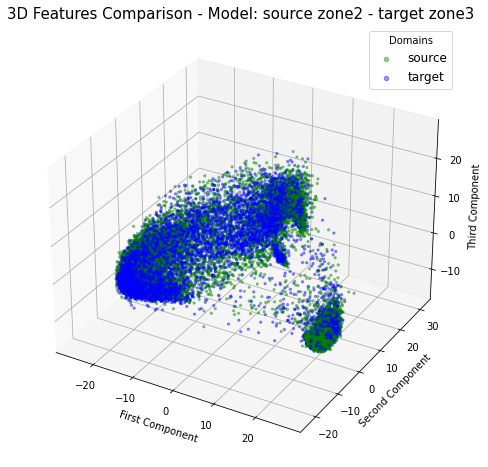

In [126]:
# PRINT 3D comparison of best and worst case
dataloaders = [(zone1dataloader,'zone1'), (zone2dataloader,'zone2'), (zone3dataloader,'zone3'), (zone4dataloader,'zone4')]
num_categories = 9
gamma = 10

# SELECT Source AND Target DOMAIN (REGION) to identify the model
# Source
i = 1 #zone number = i+1
# Target
j = 2 #zone number = i+1
sourcedataloader = dataloaders[i][0]
source_zone = dataloaders[i][1]
print('Source zone:', source_zone)
    
targetdl = dataloaders[j][0]
target_zone = dataloaders[j][1]
print('Target zone:', target_zone)

#BEST DANN MODEL = 2 --> 3 lambda max = 1
path = 'models/torch_transformer/vio_trasformer_dann_s'+str(i+1)+'_t'+ str(j+1)+'_gamma'+str(gamma)
model_dir = Path(path)
dann_model.load_state_dict(torch.load(model_dir))

source_embeddings, source_targets, source_predictions = extract_features(dann_model, sourcedataloader, device)
target_embeddings, target_targets, target_predictions = extract_features(dann_model, targetdl, device)

image_name = '3Dfeature_pca_BESTmodel_'+source_zone+target_zone
plot3D_source_target(source_zone, target_zone, 
                     source_embeddings, source_targets, source_predictions,
                     target_embeddings, target_targets, target_predictions,
                     image_name,
                     save_plot = True)

Training zone: zone1
Testing zone: zone2


100%|██████████| 40/40 [00:00<00:00, 41.63it/s]


Extracted embedded features shape (10000, 64)


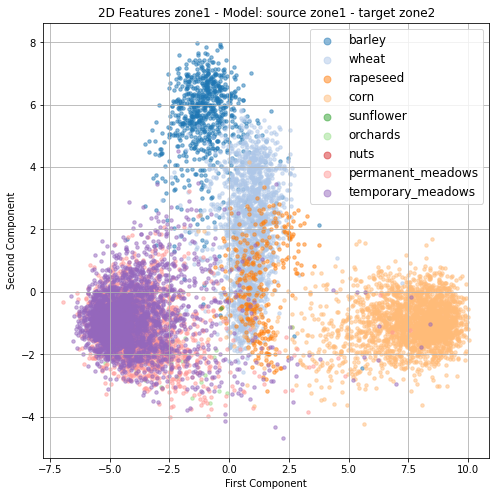

100%|██████████| 40/40 [00:00<00:00, 40.96it/s]


Extracted embedded features shape (10000, 64)


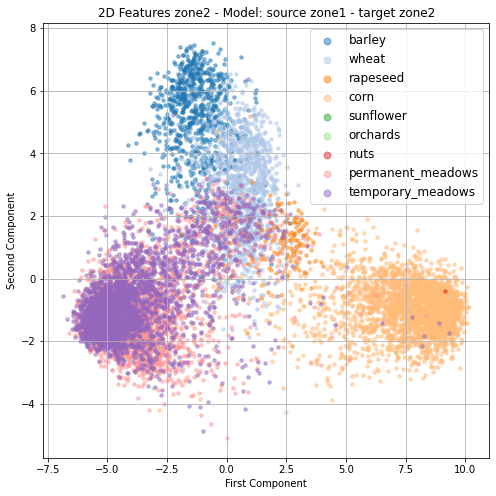

MMD for source zone 1 - target zone 2:  0.013804003
Testing zone: zone3


100%|██████████| 40/40 [00:00<00:00, 41.57it/s]


Extracted embedded features shape (10000, 64)


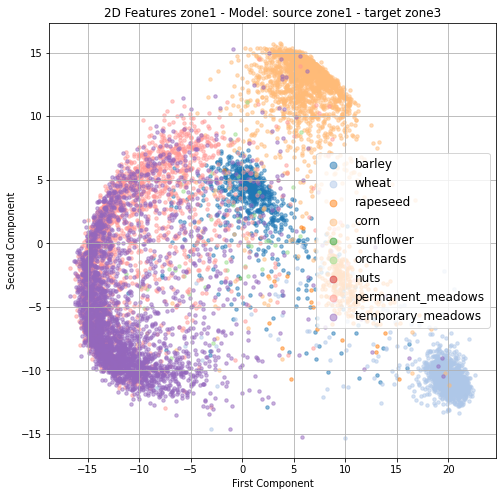

100%|██████████| 40/40 [00:00<00:00, 40.95it/s]


Extracted embedded features shape (10000, 64)


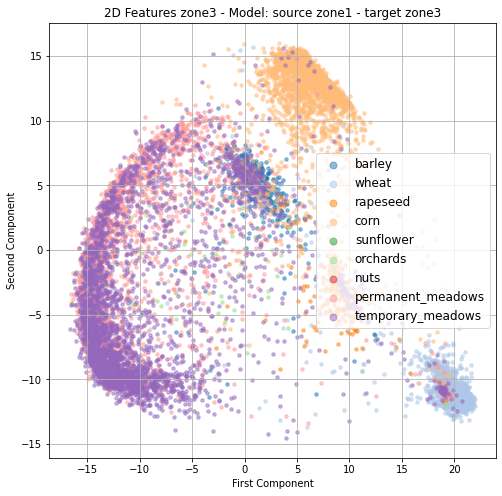

MMD for source zone 1 - target zone 3:  0.004661356
Testing zone: zone4


100%|██████████| 40/40 [00:00<00:00, 41.78it/s]


Extracted embedded features shape (10000, 64)


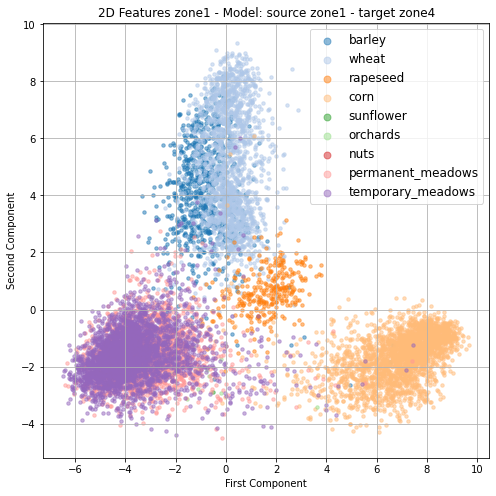

100%|██████████| 40/40 [00:00<00:00, 41.20it/s]


Extracted embedded features shape (10000, 64)


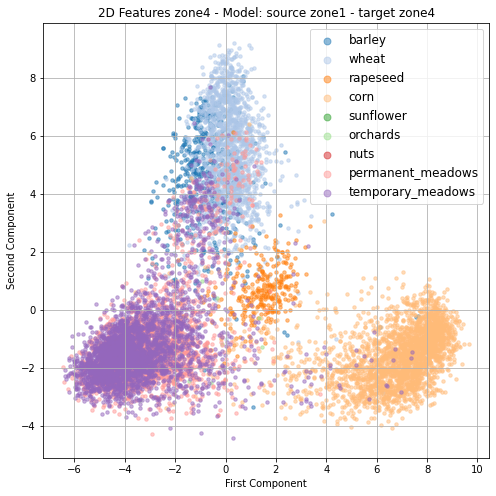

MMD for source zone 1 - target zone 4:  0.0062794774
MMD results for zone 1:  [0.013804   0.00466136 0.00627948]
Training zone: zone2
Testing zone: zone1


100%|██████████| 40/40 [00:00<00:00, 42.11it/s]


Extracted embedded features shape (10000, 64)


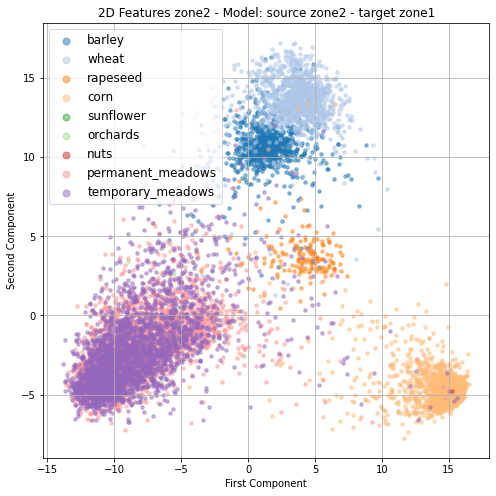

100%|██████████| 40/40 [00:00<00:00, 41.74it/s]


Extracted embedded features shape (10000, 64)


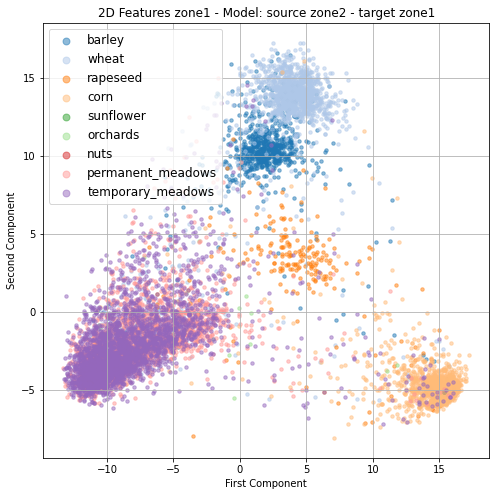

MMD for source zone 2 - target zone 1:  0.007461273
Testing zone: zone3


100%|██████████| 40/40 [00:00<00:00, 41.71it/s]


Extracted embedded features shape (10000, 64)


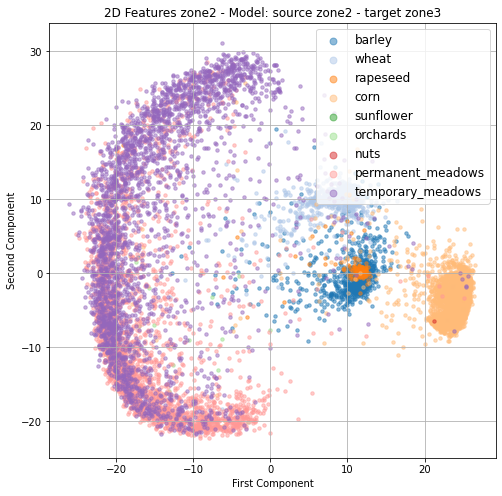

100%|██████████| 40/40 [00:01<00:00, 37.07it/s]


Extracted embedded features shape (10000, 64)


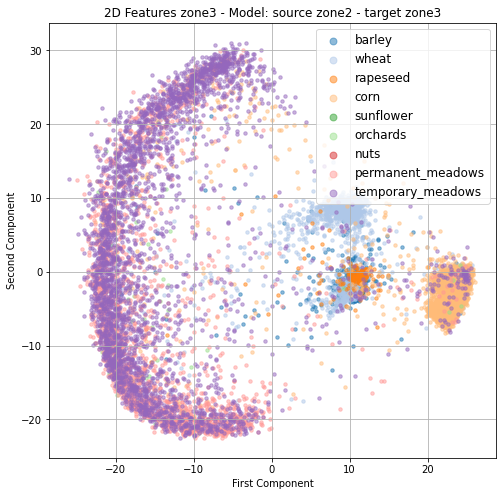

MMD for source zone 2 - target zone 3:  0.004061933
Testing zone: zone4


100%|██████████| 40/40 [00:00<00:00, 41.64it/s]


Extracted embedded features shape (10000, 64)


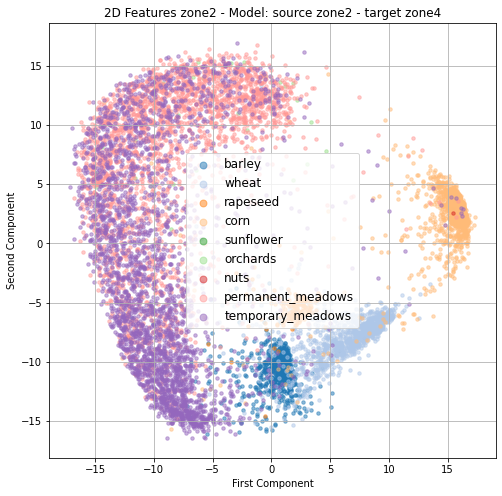

100%|██████████| 40/40 [00:00<00:00, 41.00it/s]


Extracted embedded features shape (10000, 64)


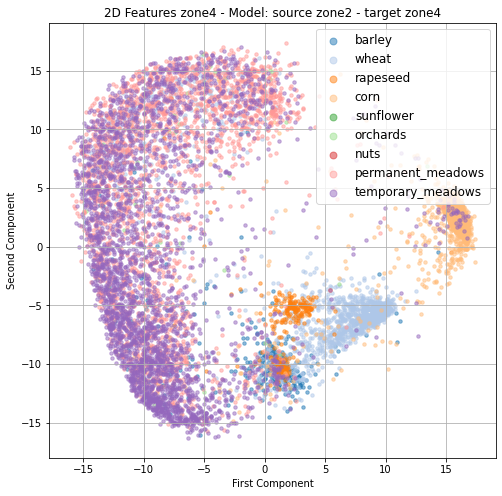

MMD for source zone 2 - target zone 4:  0.0039431956
MMD results for zone 2:  [0.00746127 0.00406193 0.0039432 ]
Training zone: zone3
Testing zone: zone1


100%|██████████| 40/40 [00:00<00:00, 41.22it/s]


Extracted embedded features shape (10000, 64)


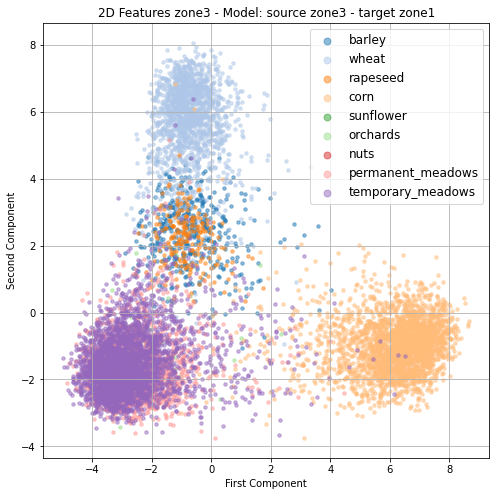

100%|██████████| 40/40 [00:00<00:00, 41.38it/s]


Extracted embedded features shape (10000, 64)


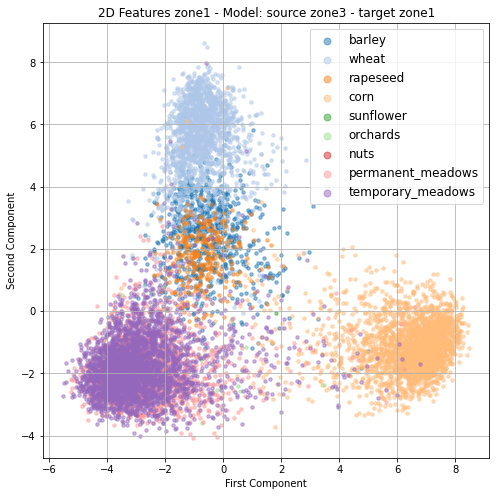

MMD for source zone 3 - target zone 1:  0.023087194
Testing zone: zone2


100%|██████████| 40/40 [00:00<00:00, 41.78it/s]


Extracted embedded features shape (10000, 64)


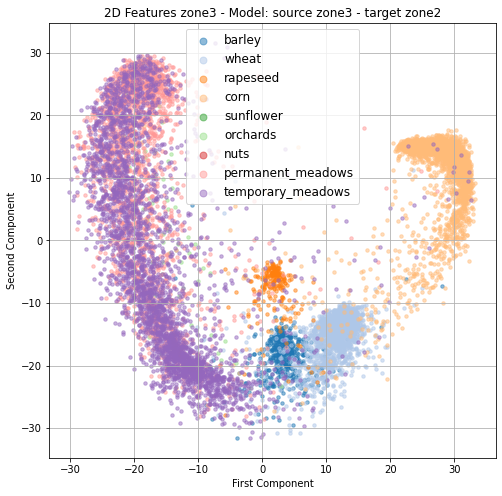

100%|██████████| 40/40 [00:00<00:00, 41.30it/s]


Extracted embedded features shape (10000, 64)


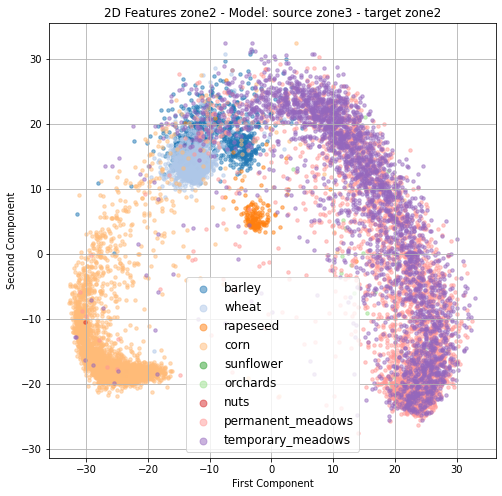

MMD for source zone 3 - target zone 2:  0.003737614
Testing zone: zone4


100%|██████████| 40/40 [00:00<00:00, 41.51it/s]


Extracted embedded features shape (10000, 64)


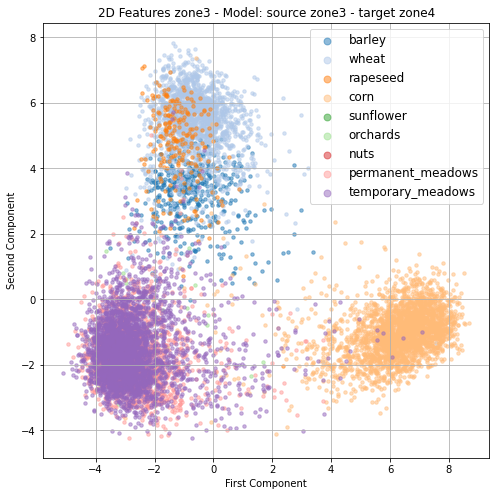

100%|██████████| 40/40 [00:00<00:00, 41.64it/s]


Extracted embedded features shape (10000, 64)


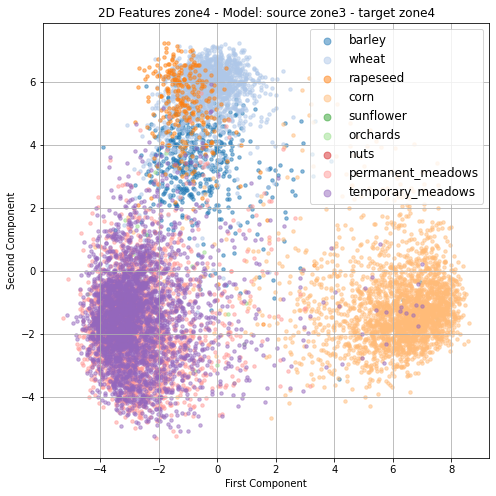

MMD for source zone 3 - target zone 4:  0.025186026
MMD results for zone 3:  [0.02308719 0.00373761 0.02518603]
Training zone: zone4
Testing zone: zone1


100%|██████████| 40/40 [00:00<00:00, 42.22it/s]


Extracted embedded features shape (10000, 64)


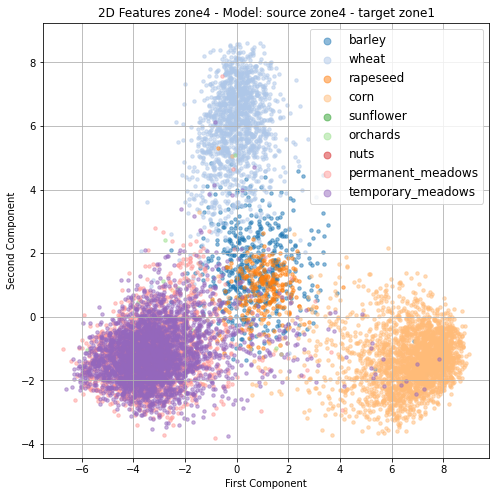

100%|██████████| 40/40 [00:00<00:00, 41.94it/s]


Extracted embedded features shape (10000, 64)


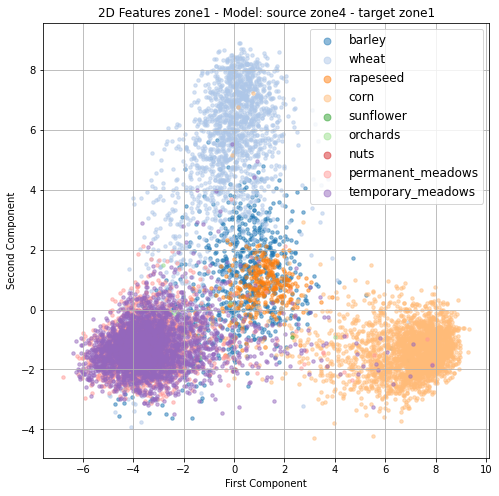

MMD for source zone 4 - target zone 1:  0.0042103655
Testing zone: zone2


100%|██████████| 40/40 [00:01<00:00, 36.72it/s]


Extracted embedded features shape (10000, 64)


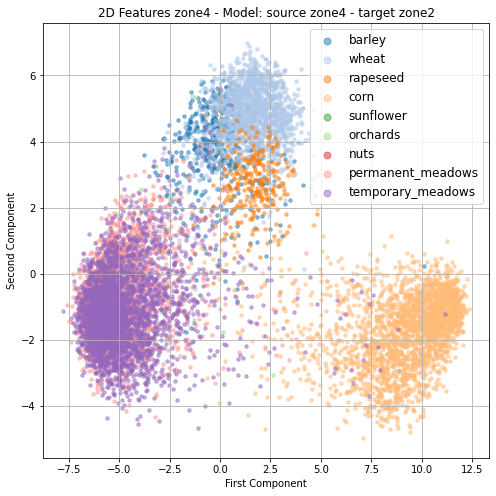

100%|██████████| 40/40 [00:00<00:00, 41.38it/s]


Extracted embedded features shape (10000, 64)


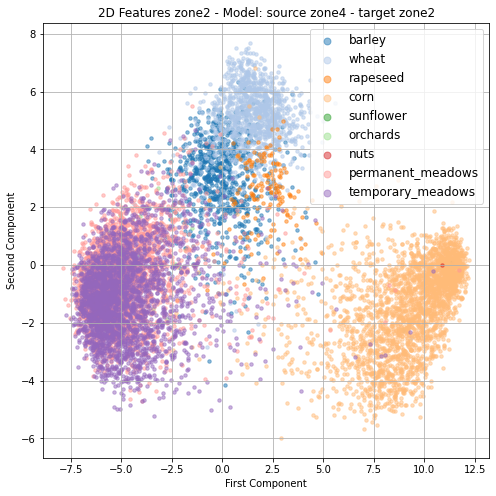

MMD for source zone 4 - target zone 2:  0.009731948
Testing zone: zone3


100%|██████████| 40/40 [00:00<00:00, 40.99it/s]


Extracted embedded features shape (10000, 64)


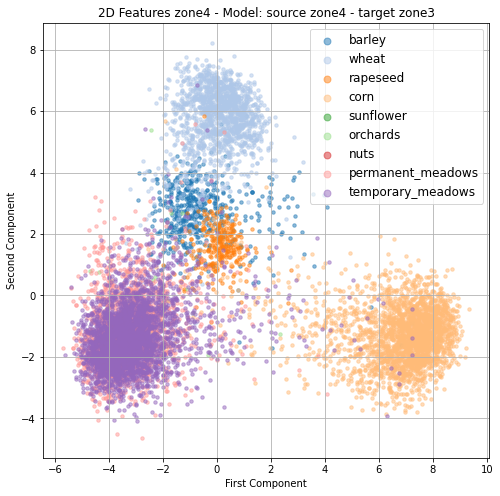

100%|██████████| 40/40 [00:00<00:00, 41.33it/s]


Extracted embedded features shape (10000, 64)


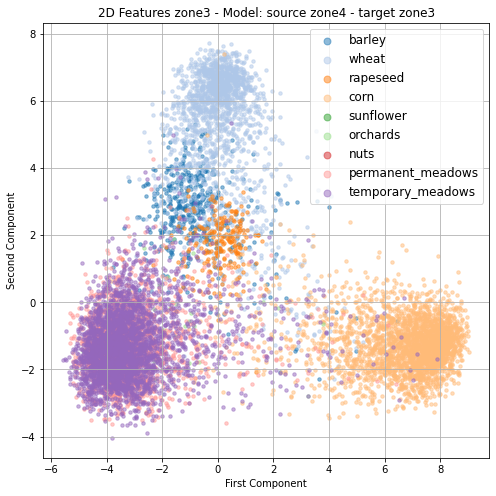

MMD for source zone 4 - target zone 3:  0.0103267385
MMD results for zone 4:  [0.00421037 0.00973195 0.01032674]


In [136]:
dataloaders = [(zone1dataloader,'zone1'), (zone2dataloader,'zone2'), (zone3dataloader,'zone3'), (zone4dataloader,'zone4')]
num_categories = 9
alpha_c = 0.2
gamma = 10

for i in range(zones):
    mmd_results = []
    
    traindataloader = dataloaders[i][0]
    train_zone = dataloaders[i][1]
    print('Training zone:', train_zone)
    
    for j in range(zones):
        if j!= i:
            testdl = dataloaders[j][0]
            test_zone = dataloaders[j][1]
            print('Testing zone:', test_zone)
            source_zone = train_zone
            target_zone = test_zone
            
            path = 'models/torch_transformer/vio_trasformer_dann_s'+str(i+1)+'_t'+ str(j+1)+'_gamma'+str(gamma)
            #path = 'models/torch_transformer/vio_trasformer_dann_s'+str(i+1)+'_t'+ str(j+1)+'_maxalpha02_gamma'+str(gamma)
            model_dir = Path(path)
            dann_model.load_state_dict(torch.load(model_dir))
  
            train_embeddings, train_targets, train_predictions = extract_features(dann_model, traindataloader, device)
            pca_train_embs = plot2Dpca(train_zone, source_zone, target_zone, train_embeddings, train_targets, train_predictions, save_plot = True)
    
            test_embeddings, test_targets, test_predictions = extract_features(dann_model, testdl, device)
            pca_test_embs = plot2Dpca(test_zone, source_zone, target_zone, test_embeddings, test_targets, test_predictions, save_plot = True)

            train_embs = torch.as_tensor(train_embeddings)
            test_embs = torch.as_tensor(test_embeddings)

            mmd = MMD(train_embs, test_embs, 'rbf')
            mmd = mmd.detach().cpu().numpy()
            print('MMD for source zone {} - target zone {}: '.format(str(i+1), str(j+1)), mmd)
            mmd_results.append(mmd)
    mmd_results = np.asarray(mmd_results)
    print('MMD results for zone {}: '.format(str(i+1)), mmd_results)
    np.save('feature_visualization/DANN/'+train_zone+'/MMD_results_zone{}'.format(str(i+1)), mmd_results)

# t-sne

In [ ]:
from sklearn.manifold import TSNE
from matplotlib import cm

# Create a two dimensional t-SNE projection of the embeddings
tsne = TSNE(2, verbose=1)
tsne_proj = tsne.fit_transform(test_embeddings)


In [ ]:
# 2D Plot those points as a scatter plot and label them based on the pred labels
cmap = cm.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(8,8))
num_categories = 9
for lab in range(num_categories):
    indices = test_predictions==lab
    ax.scatter(tsne_proj[indices,0],tsne_proj[indices,1], c=np.array(cmap(lab)).reshape(1,4), label = lab ,alpha=0.5)
ax.legend(fontsize='large', markerscale=2)
plt.show()

In [ ]:
tsne = TSNE(3, verbose=1)
tsne_proj = tsne.fit_transform(test_embeddings)
cmap = cm.get_cmap('tab20')
num_categories = 9
for lab in range(num_categories):
    indices = test_predictions == lab
    ax.scatter(tsne_proj[indices, 0],
               tsne_proj[indices, 1],
               tsne_proj[indices, 2],
               c=np.array(cmap(lab)).reshape(1, 4),
               label=lab,
               alpha=0.5)
ax.legend(fontsize='large', markerscale=2)
plt.show()